<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

please watch : https://www.youtube.com/watch?v=581X9wsnWJs  => CNRS video YT 27:26 min complet explanation  about CNN

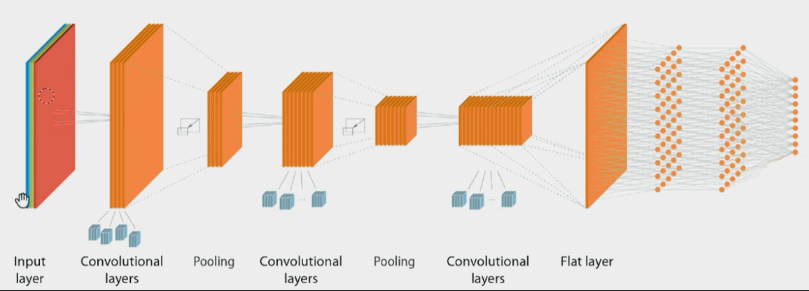

# <!-- TITLE --> 16 - Simple classification with CNN - [MNIST2]
<!-- DESC --> An example of classification using a convolutional neural network for the famous MNIST dataset
<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Recognizing handwritten numbers
 - Understanding the principle of a classifier DNN network 
 - Implementation with Keras 


The [MNIST dataset](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) is a must for Deep Learning.  
It consists of 60,000 small images of handwritten numbers for learning and 10,000 for testing.


## What we're going to do :

 - Retrieve data
 - Preparing the data
 - Create a model
 - Train the model
 - Evaluate the result


## Step 1 - installation des packages utiles

In [12]:
# MODIFICATION : Version simplifi√©e sans d√©pendance √† fidle ni gestion de dossiers inutiles

# Installer les packages n√©cessaires (√† activer si sur Google Colab)
# !pip install torch torchvision torchaudio keras numpy matplotlib scikit-learn

import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras
import numpy as np
import matplotlib.pyplot as plt


Verbosity during training : 0 = silent, 1 = progress bar, 2 = one line per epoch

Override parameters (batch mode) - Just forget this cell

## Step 2 - R√©cup√©ration des donn√©es
MNIST is one of the most famous historic dataset.  
Include in [Keras datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets)

In [13]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print("x_train : ",x_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",x_test.shape)
print("y_test  : ",y_test.shape)

x_train :  (60000, 28, 28)
y_train :  (60000,)
x_test  :  (10000, 28, 28)
y_test  :  (10000,)


In [14]:
x_train[1].shape # image 2, 28 lignes par 28 colonnes de valeurs entre 0 et 255 Noir->Blanc

(28, 28)

In [15]:
# ici nos images ont 1 seul canal (niveau de gris)

x_train = x_train.reshape(-1,28,28,1) # ajoute 1 dimension pour le canal de niveaux de gris
# -1 : cette dimension sera calcul√©e automatiquement pour inclure tous les √©chantillons (60000 pour x_train et 10000 pour x_test).
# 28, 28 : la hauteur et la largeur de chaque image.
# 1 : le nombre de canaux, qui est 1 pour les images en niveaux de gris.

x_test  = x_test.reshape(-1,28,28,1)

print("x_train : ",x_train.shape)
print("y_train : ",y_train.shape)
print("x_test  : ",x_test.shape)
print("y_test  : ",y_test.shape)

# donne pour x_train : 60000 image en 28 x 28 sur 1 canal de couleur

x_train :  (60000, 28, 28, 1)
y_train :  (60000,)
x_test  :  (10000, 28, 28, 1)
y_test  :  (10000,)


## Step 3 - Preparing the data

In [16]:
print('Before normalization : Min={}, max={}'.format(x_train.min(),x_train.max()))

xmax=x_train.max()
x_train = x_train / xmax
x_test  = x_test  / xmax

print('After normalization  : Min={}, max={}'.format(x_train.min(),x_train.max()))

Before normalization : Min=0, max=255
After normalization  : Min=0.0, max=1.0


### Have a look

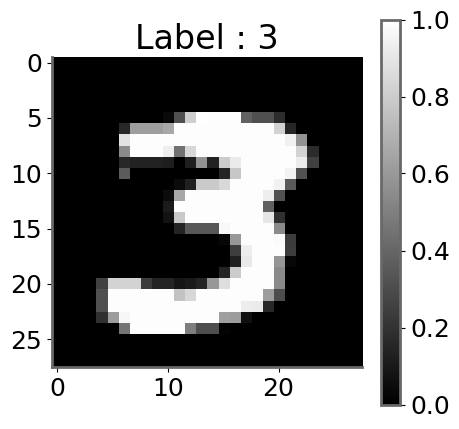

In [17]:
# Afficher une image unique
plt.figure(figsize=(5, 5))
plt.imshow(x_train[27].squeeze(), cmap='gray')  # Utilisez .squeeze() pour supprimer la dimension de canal
plt.colorbar()
plt.title(f"Label : {y_train[27]}")
#plt.savefig('one-digit.png')  # Sauvegarder l'image
plt.show()


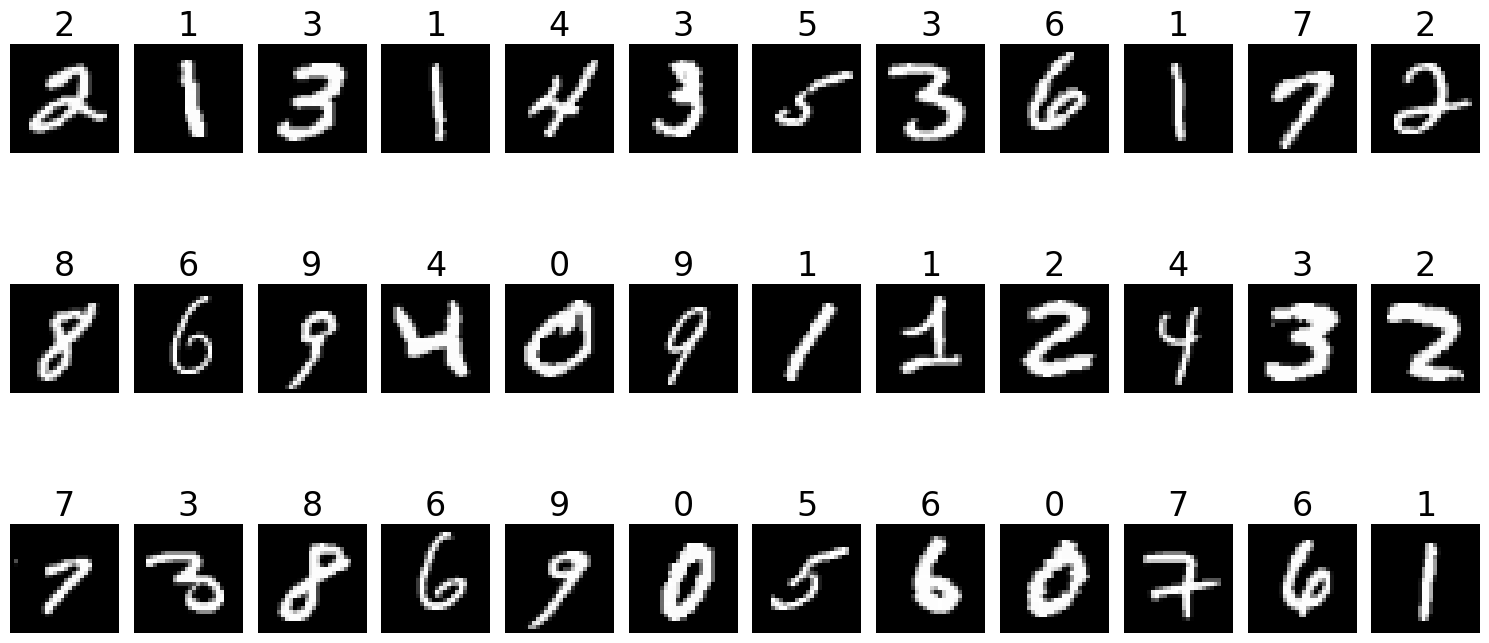

In [18]:
# D√©finir les indices et param√®tres d'affichage
indices = range(5, 41)
columns = 12
rows = (len(indices) + columns - 1) // columns  # Calculer le nombre de lignes n√©cessaire

plt.figure(figsize=(15, 8))  # Ajustez la taille de la figure pour correspondre aux images

for i, idx in enumerate(indices):
    plt.subplot(rows, columns, i + 1)
    plt.imshow(x_train[idx].squeeze(), cmap='gray')
    plt.title(f"{y_train[idx]}")  # on affiche les √©tiquettes y de nos datas X
    plt.axis('off')  # Masquer les axes pour un affichage plus propre

plt.tight_layout()
#plt.savefig('many-digits.png')  # Sauvegarder l'image
plt.show()


## Step 4 - Create model
About informations about : 
 - [Optimizer](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
 - [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/activations)
 - [Loss](https://www.tensorflow.org/api_docs/python/tf/keras/losses)
 - [Metrics](https://www.tensorflow.org/api_docs/python/tf/keras/metrics)

 ## üåê Comprendre les concepts cl√©s d‚Äôun r√©seau de neurones convolutif (CNN)

Voici les notions fondamentales utilis√©es dans notre mod√®le CNN :

---

### üîπ <span style="color:royalblue"><b>Convolution</b></span>
La convolution est une op√©ration math√©matique qui applique un **filtre (ou kernel)** sur une image pour en extraire des **caract√©ristiques locales** (bords, motifs...).  
On glisse le filtre sur l'image (comme une loupe) et on calcule une somme pond√©r√©e des pixels.

- <span style="color:orange"><b>Padding</b></span> : ajoute une bordure autour de l'image d'origine pour **conserver sa taille** apr√®s convolution.  
  - Exemple : un padding `same` conserve les dimensions.
- <span style="color:teal"><b>Strides</b></span> : d√©finit le **pas de d√©placement** du filtre.  
  - Un stride de `1` glisse pixel par pixel, `2` saute 1 pixel √† chaque fois ‚Üí r√©duction de taille.

---

### üîπ <span style="color:seagreen"><b>Pooling</b></span>
Le pooling r√©duit la dimension d‚Äôune image en prenant une valeur r√©sum√©e (souvent **max ou moyenne**) dans une petite zone.  
Cela diminue le **nombre de param√®tres** et rend le mod√®le **plus robuste** aux petites variations de position.

- Exemple : <span style="color:seagreen"><b>MaxPooling(2,2)</b></span> prend le maximum sur une zone de 2√ó2 pixels.

---

### üîπ <span style="color:darkviolet"><b>Flat Layer (Flatten)</b></span>
Apr√®s les convolutions et poolings, les images deviennent de petits **blocs multidimensionnels**.  
La couche `Flatten` transforme ce **volume** (ex : 7√ó7√ó16) en **vecteur lin√©aire** (ex : 784) pour l'envoyer dans une couche dense (classique).

---

### üîπ <span style="color:brown"><b>Kernel</b></span>
Un **kernel** est un petit tableau de poids (ex : 3√ó3) appliqu√© √† chaque position de l'image.  
Il agit comme un **filtre** apprenant √† d√©tecter une caract√©ristique (ex : bord horizontal, texture...).

Chaque neurone convolutif apprend son propre **kernel** pendant l'entra√Ænement.

---

### üîπ <span style="color:crimson"><b>Dropout</b></span>
Technique de r√©gularisation : pendant l'entra√Ænement, une fraction al√©atoire des neurones est **d√©sactiv√©e** (mise √† z√©ro).  
Cela emp√™che certains neurones de devenir trop dominants et **limite le surapprentissage (overfitting)**.

- Exemple : `Dropout(0.5)` d√©sactive **50 % des neurones** √† chaque it√©ration (pendant le training uniquement).

---


In [19]:
model = keras.models.Sequential()                                       # on instancie notre mod√®le de convolution en mode s√©quentiel (pas √† pas)

model.add( keras.layers.Input((28,28,1)) )                              # on y ajoute notre 1ere couche d'entr√©e sur des objets de taille (28, 28, 1)

model.add( keras.layers.Conv2D(8, (3,3),  activation='relu') )          # on ajoute 8 couches convolutives en sortie, avec kernel (3x3) et un sigma d'activation RELU (conv 2D car matrice 28x28, conv 1D pour les courbes ...)
model.add( keras.layers.MaxPooling2D((2,2)))                            # on r√©duit par 2 sur chaque dimension nos plans de sortie avec max pooling de kernel (2,2) => images deviennent (14,14) si padding (12,12) sinon
model.add( keras.layers.Dropout(0.2))                                   # nouveau, que pour l'apprentissage, force les sortie √† devenir 0 sur 20% des sortie (0.2) de fa√ßon al√©atoire ! 
                                                                        # => pour pas que certains neurones prennent trop d'importance sur d'autres neurones = on d√©active des neurones au hasard et tous sont d√©activ√©s 1 fois

model.add( keras.layers.Conv2D(16, (3,3), activation='relu') )          # on refait notre convolution mais avec 16 couches de sorties cette fois
model.add( keras.layers.MaxPooling2D((2,2)))                            # on redivise la taille des plans de sortie en 2 par max pooling ici
model.add( keras.layers.Dropout(0.2))                                   # on d√©active encore al√©atoirement 20% des neurones en phases d'appentissages

model.add( keras.layers.Flatten())                                      # enfin on aplatit nos plans de sortie en 1 seul plan
model.add( keras.layers.Dense(100, activation='relu'))                  # on ajoute une couche de 100 neurones totalement connect√©s
model.add( keras.layers.Dropout(0.5))                                   # dropout final de 50% => ici bon r√©sultat, choisi sur x tests

model.add( keras.layers.Dense(10, activation='softmax'))                # fin avec 10 neurones de sortie (car on veut pr√©dire les chiffres de 0 √† 9 soit 10 en tout) avec activation SOFTMAX car on fait de la classification !

In [20]:
model.summary()

model.compile(optimizer='adam',                         
              loss='sparse_categorical_crossentropy',   
              metrics=['accuracy'])

# fonction de descente de gradien de type adam (Adaptive Moment Estimation) est un optimiseur avanc√©, souvent pr√©f√©r√© car il combine les avantages des algorithmes AdaGrad et RMSProp. 
# Il ajuste les taux d'apprentissage individuellement pour chaque param√®tre, en utilisant √† la fois la moyenne des gradients (comme RMSProp) et la moyenne des carr√©s des gradients (comme AdaGrad).

# fonction de perte ou  de co√ªt mesure l'erreur entre les pr√©dictions du mod√®le et les valeurs cibles (labels) afin de guider l'optimisation. 
# Ici, sparse_categorical_crossentropy est utilis√©e pour les probl√®mes de classification multi-classes, comme dans le cas de la classification des chiffres MNIST (de 0 √† 9). 

Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                    ‚îÉ Output Shape           ‚îÉ       Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ conv2d_2 (Conv2D)               ‚îÇ (None, 26, 26, 8)      ‚îÇ            80 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_2 (MaxPooling2D)  ‚îÇ (None, 13, 13, 8)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)             ‚îÇ (None, 13, 13, 8)      ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv2d_3 (Conv2D)               ‚îÇ (None, 11, 11, 16)     ‚îÇ         1,168 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ max_pooling2d_3 (MaxPooling2D)  ‚îÇ (None, 5, 5, 16)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)             ‚îÇ (None, 5, 5, 16)       ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_1 (Flatten)             ‚îÇ (None, 400)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                 ‚îÇ (None, 100)            ‚îÇ        40,100 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_5 (Dropout)             ‚îÇ (None, 100)            ‚îÇ             0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                 ‚îÇ (None, 10)             ‚îÇ         1,010 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 42,358 (165.46 KB)

 Trainable params: 42,358 (165.46 KB)

 Non-trainable params: 0 (0.00 B)

## explications

### Output Shape
- 0. notre couche d'entr√©e INPUT (28,28,1) n'apparait pas ici dans les r√©sultat
- 1. CONV2D => pas de padding donc on perd 1 pixel de chaque c√¥t√© des images => (26,26,1) + 8 plans convolutifs => (26,26,8)
- 2. POLLING avec max() , donc on divise par 2 la taille des plans conv => (13,13,8)
- 3. RAS dropout
- 4. CONV2D => idem, on perd 1 pixel partout (haut,bas,droite,gauche) et 16 plans conv => (11,11,16)
- 5. POLLING avec max() , donc on divise par 2 la taille des plans conv => (5,5,16)
- 6. RAS dropout
- 7. on FLAT nos 16 plans trop petit √† pr√©sent de (5,5) => 5x5x16 = 400 pixels en 1 seul plan (image)
- 8. puis on ajoute nos 100 neurones connect√©s qui prennent en input notre flatten
- 9. on dropout encore √† 50% (plusieurs tests fait pour avoir ici le 0.5 retenu)
- 10. c'est notre plan de sortie fianl √† 10 neurones pour classer de 0 √† 9 nos images 

### Params
- 1. CONV2D : entr√©e (28,28,1), nbre filtres (kernels) est 8 car 8 plans de conv. de taille 3x3 par kernel avec 1 param de biais par kernel => 3x3x1x8 = param noyaux x 8 filtres + 8 biais => 3x3x1x8 + 8 = 80 params
- 4. CONV2D : entr√©e (13,13,8), nbre filtres 16 en 3x3 => 3x3x8x16 +16 = 1.168 params
- 8. ANN 100 neurones denses : entr√©e (400), avec 100 neurones + 100 biais => 400x100 + 100 = 40.100
- 10. ANN 10 neurones de sortie : entr√©e (100), avec 10 neurones + 10 biais => 100x10 + 10 = 1.010


## Step 5 - Entrainenemt du mod√®le

### batch size  :
- D√©finition : c'est le nombre d'√©chantillons d'entra√Ænement que le mod√®le traite avant de mettre √† jour les poids.
- => ici le mod√®le traite 512 images avant de mettre √† jour ses poids.   
- Un batch size plus grand peut acc√©l√©rer l'entra√Ænement (en utilisant plus de donn√©es √† la fois), mais n√©cessite plus de m√©moire.    
- Un batch size plus petit permet des mises √† jour plus fr√©quentes des poids, mais peut rendre l'entra√Ænement plus lent.

### epochs :
- D√©finition : Une √©poque (epoch) est une passe compl√®te sur tout le jeu de donn√©es d'entra√Ænement.
- => ici : on d√©finit epochs = 16, donc le mod√®le va voir l'ensemble de vos donn√©es d'entra√Ænement 16 fois au total.
- Impact : Un nombre √©lev√© d'√©poques permet au mod√®le d'apprendre davantage, mais au risque de sur-apprentissage (overfitting) si le mod√®le apprend trop bien les d√©tails du jeu de donn√©es d'entra√Ænement.

### accuracy (Pr√©cision sur les donn√©es d'entra√Ænement)
- D√©finition : La pr√©cision est la proportion de pr√©dictions correctes sur le jeu de donn√©es d'entra√Ænement.
- Interpr√©tation : Plus la valeur de accuracy se rapproche de 1 (ou de 100%), mieux le mod√®le parvient √† pr√©dire les classes des images sur les donn√©es d'entra√Ænement.
- √âvolution : On voit que accuracy augmente progressivement d'une √©poque √† l'autre, ce qui est bon signe. Cela montre que le mod√®le s'am√©liore en apprenant des donn√©es.
### loss (Fonction de perte sur les donn√©es d'entra√Ænement)
- D√©finition : La fonction de perte mesure l'erreur entre les pr√©dictions du mod√®le et les vraies valeurs. Pour un mod√®le de classification multi-classes, on utilise souvent sparse_categorical_crossentropy.
- Interpr√©tation : Plus la valeur de loss est faible, plus le mod√®le a de bonnes pr√©dictions. En d'autres termes, une diminution de loss indique que le mod√®le apprend √† r√©duire l'erreur sur les donn√©es d'entra√Ænement.
√âvolution : La valeur de loss diminue progressivement au fil des √©poques, ce qui est un bon signe indiquant que le mod√®le s'adapte mieux aux donn√©es.
### val_accuracy (Pr√©cision sur les donn√©es de validation/test)
- D√©finition : val_accuracy est la pr√©cision du mod√®le sur le jeu de donn√©es de test (ou validation), qui est un ensemble de donn√©es diff√©rent du jeu d'entra√Ænement.
- Interpr√©tation : Cela montre dans quelle mesure le mod√®le est capable de g√©n√©raliser sur des donn√©es qu'il n'a jamais vues.
- √âvolution : On remarque que val_accuracy augmente √©galement au fil des √©poques, ce qui est bon signe. Elle atteint des valeurs √©lev√©es (au-dessus de 98 %), ce qui indique que le mod√®le g√©n√©ralise bien.
### val_loss (Fonction de perte sur les donn√©es de validation/test)
- D√©finition : val_loss est la valeur de la fonction de perte calcul√©e sur le jeu de donn√©es de validation.
- Interpr√©tation : Un val_loss faible indique que le mod√®le parvient √† minimiser l'erreur sur les donn√©es de test, montrant ainsi une bonne capacit√© de g√©n√©ralisation.
- √âvolution : Comme pour loss, val_loss diminue au fil des √©poques. Elle reste globalement basse, ce qui est un indicateur que le mod√®le n'est pas en sur-apprentissage (pas d'augmentation significative de val_loss).

### R√©sultats sur l'√âvolution des valeurs
En regardant les valeurs sur chaque √©poque :

- accuracy et val_accuracy augmentent : Cela signifie que le mod√®le devient plus pr√©cis, aussi bien sur les donn√©es d'entra√Ænement que de validation, ce qui est souhaitable.
- loss et val_loss diminuent : Cela montre que le mod√®le apprend √† mieux r√©duire les erreurs sur les deux ensembles de donn√©es, un autre bon signe.
- Si val_loss commen√ßait √† augmenter tandis que loss continuait de diminuer, cela pourrait indiquer un surapprentissage (overfitting), o√π le mod√®le s‚Äôadapte trop aux donn√©es d‚Äôentra√Ænement au d√©triment de sa capacit√© √† g√©n√©raliser. - Cependant, ici, les valeurs semblent bien se stabiliser et suivre des trajectoires similaires, indiquant un bon apprentissage.


In [21]:
batch_size  = 512 
epochs      =  16

fit_verbosity = 1  # 0 = silence, 1 = barre de progression, 2 = une ligne par epoch


history = model.fit(  x_train, y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = fit_verbosity,
                      validation_data = (x_test, y_test))

Epoch 1/16
118/118 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 56ms/step - accuracy: 0.4702 - loss: 1.5631 - val_accuracy: 0.9224 - val_loss: 0.2803
Epoch 2/16
118/118 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 55ms/step - accuracy: 0.8711 - loss: 0.4285 - val_accuracy: 0.9532 - val_loss: 0.1583
Epoch 3/16
118/118 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 54ms/step - accuracy: 0.9094 - loss: 0.2946 - val_accuracy: 0.9626 - val_loss: 0.1182
Epoch 4/16
118/118 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 59ms/step - accuracy: 0.9270 - loss: 0.2426 - val_accuracy: 0.9691 - val_loss: 0.1005
Epoch 5/16
118/118 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 54ms/step - accuracy: 0.9368 - loss: 0.2078 - val_accuracy: 0.9723 - val_loss: 0.0883
Epoch 6/16
118/118 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 55ms/step - accuracy: 0.9427 - loss: 0.1871 - val_accuracy: 0.9760 - val

## Step 6 - Evaluate
### 6.1 - Final loss and accuracy
Note : With a DNN, we had a precision of the order of : 97.7%

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

Test loss     : 0.0437
Test accuracy : 0.9864


### Test loss : 0.0402

- Interpr√©tation : La fonction de perte (loss) de 0.0402 indique une erreur moyenne relativement faible entre les pr√©dictions du mod√®le et les labels r√©els sur les donn√©es de test.
- Signification : Un score de perte bas signifie que le mod√®le a bien appris √† pr√©dire les classes sur des donn√©es qu'il n'a jamais vues. Cela indique que le mod√®le est pr√©cis et que l'erreur est minime, ce qui est un bon signe de performance.
### Test accuracy : 0.9867
- Interpr√©tation : La pr√©cision (accuracy) de 0.9867 (ou 98.67 %) signifie que le mod√®le a correctement pr√©dit la classe des images dans 98,67 % des cas sur le jeu de donn√©es de test.
- Signification : Une pr√©cision √©lev√©e, proche de 100 %, indique que le mod√®le est tr√®s performant pour classer les images MNIST (chiffres de 0 √† 9). Ce r√©sultat est excellent et montre que le mod√®le g√©n√©ralise bien, en restant pr√©cis sur des donn√©es non vues.
### En r√©sum√© :
Ces r√©sultats sugg√®rent que votre mod√®le est tr√®s efficace pour la t√¢che de classification MNIST. Il a une tr√®s faible erreur et une tr√®s haute pr√©cision sur le jeu de donn√©es de test, ce qui signifie qu'il est bien entra√Æn√© et peut g√©n√©raliser avec succ√®s sur de nouvelles images.

### 6.2 - Plot history

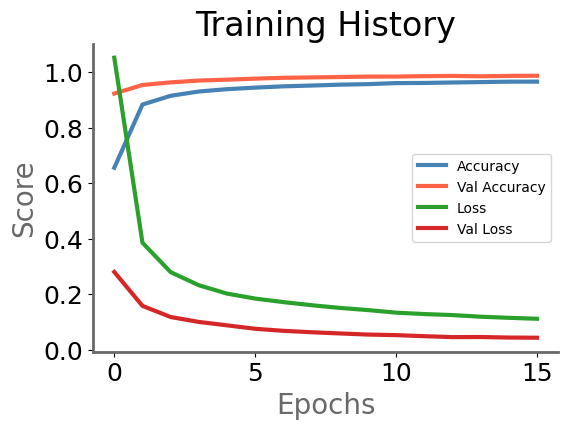

In [24]:
import matplotlib.pyplot as plt

# Afficher l'historique de l'entra√Ænement
plt.figure(figsize=(6, 4))
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.title('Training History')
#plt.savefig('history.png')  # Sauvegarder l'image
plt.show()


### 6.3 - Plot results

  1/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 39ms/step

313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step


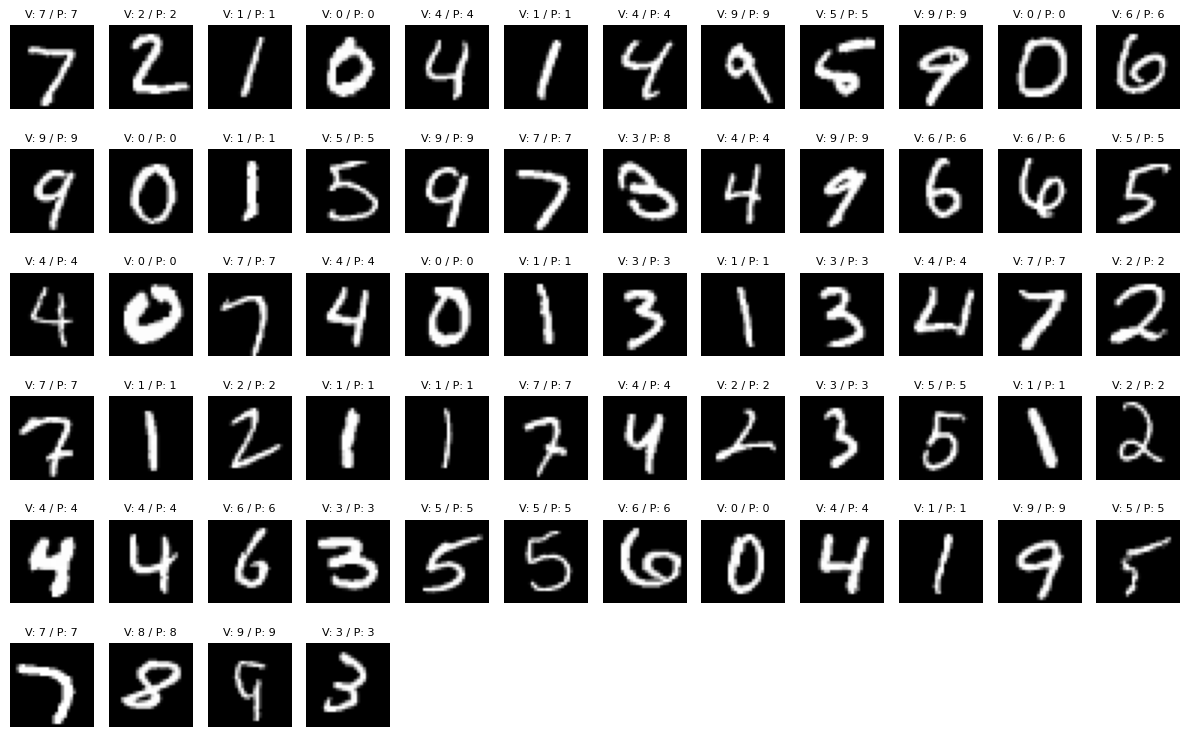

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Pr√©dire les classes pour les images de test
y_sigmoid = model.predict(x_test)
y_pred = np.argmax(y_sigmoid, axis=-1)

# Afficher les images avec les vraies √©tiquettes et les pr√©dictions
plt.figure(figsize=(12, 20))
for i in range(64):  # Affiche les 200 premi√®res images
    plt.subplot(16, 12, i + 1)  # Cr√©e une grille 16x12 pour afficher 200 images
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"V: {y_test[i]} / P: {y_pred[i]}", fontsize=8)
    plt.axis('off')

plt.tight_layout()
#plt.savefig('predictions.png')  # Sauvegarder l'image sous '04-predictions.png'
plt.show()


### 6.4 - Plot some errors

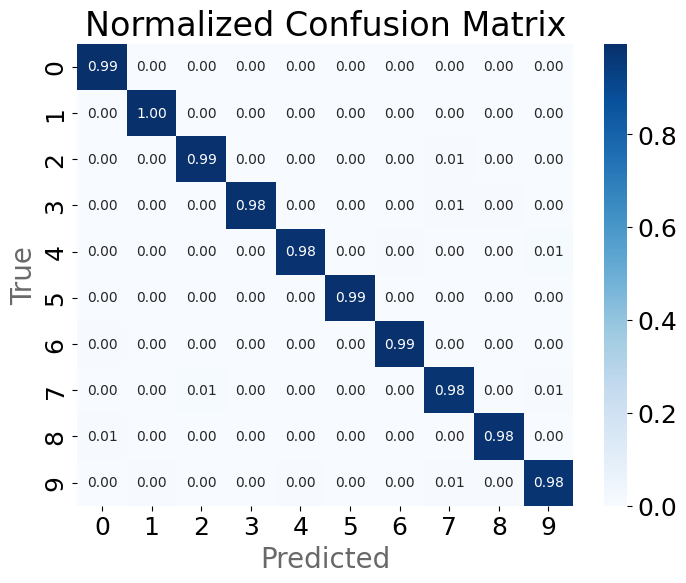

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt=".2f", cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
#plt.savefig('confusion-matrix.png')  # Sauvegarder l'image
plt.show()
